# Project: PubMed 200k RCT

The purpose of the project is to build an NLP model to make reading medical abstracts easier.


## Confirm access to a gpu

In [ ]:
!nvidia-smi

Mon Feb 27 01:57:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get data

Downloading the dataset from official Pubmed 200k RCT github repository.

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 6.82 MiB/s, done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# Check the files in the PubMed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/
!ls pubmed-rct/PubMed_20k_RCT/

dev.txt  test.txt  train.txt
dev.txt  test.txt  train.txt


In [ ]:
# Start the experiments using 20K dataset with numbers replaced by "@" symbol
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# Check all of the filenames in the target directory
import os 
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess data

A function to read all of the lines of a target text file.

In [ ]:
# Create fn to read the lines of a doc
def get_lines(filename):
  """
  Reads filename (a text filename) returns the lines of text as a list.

  Args:
    filename a string containing the target filepath.

    Returns:
      A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()


In [ ]:
# Read in the training lines
train_lines = get_lines(data_dir + "train.txt") # read the lines within the training files
train_lines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

How to represent the data:
* List of dictionaries:
```
[{'line_number': 0,
  'target': 'BACKGROUND',
  'text': 'Emotional eating is associated with overeating and the development of obesity .\n'
  'total_lines': 11},
     ...]
```

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a dictionary of abstract line data.

  Takes in filename reads its content and sorts through each line,
  extracting things like target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if the line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string if the line is an ID line
    
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines()  # split abstract into seperate lines
     
      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line apeear in the abstract
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are there in the abstract? (start from zero)    
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions are'nt fulfilled a line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [ ]:
# Get data from file and prerpocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 410 ms, sys: 83.9 ms, total: 494 ms
Wall time: 495 ms


In [ ]:
# Check the fisrt abstract of our traing data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
test_df.head(15)

,target,text,line_number,total_lines
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8
1,RESULTS,a post hoc analysis was conducted with the use...,1,8
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8
3,RESULTS,survival analyses were used to assess the asso...,3,8
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8
6,RESULTS,multivariable analyses revealed that patients ...,6,8
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12


In [ ]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

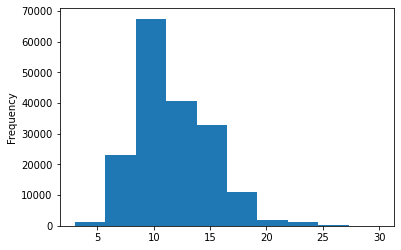

In [ ]:
# Check length of different lines
train_df.total_lines.plot.hist();

### Get a list of sentences

In [ ]:
# Convert abstract text_lines into lists
train_sentences = train_df["text"].to_list()
val_sentences = val_df["text"].to_list()
test_sentences = test_df["text"].to_list()
len(train_sentences), len(val_sentences), len(test_sentences)





(180040, 30212, 30135)

In [ ]:
# train_sentences_np = train_df["text"].to_numpy()
# val_sentences_np = val_df["text"].to_numpy()
# test_sentences_np = test_df["text"].to_numpy()

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Making Numeric labels

In [ ]:
# One hot encode the labels
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse = False) # we want a non sparsed matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))
train_labels_one_hot[:5], val_labels_one_hot[:5], test_labels_one_hot[:5]

(array([[0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]]), array([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]]), array([[1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.]]))

TensorFlow is'nt compatible with sparse matrix

### Label encode labels

In [ ]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded[:10], val_labels_encoded[:10], test_labels_encoded[:10]

(array([3, 2, 2, 2, 2, 2, 4, 4, 4, 4]),
 array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1]),
 array([0, 4, 4, 4, 4, 4, 4, 1, 1, 0]))

In [ ]:
# Get class names and number of classes from label encoder
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Satrting a series of modelling experiments

## Model 0: Getting a basline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tf_idf", TfidfVectorizer()), # convert text into numbers
    ("clf", MultinomialNB()) # model the text(i.e. learn patterns)
])

model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tf_idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# evaluate the basline model
baseline_score = model_0.score(val_sentences, val_labels_encoded)
print(f"Acccuracy of baseline model is {baseline_score * 100:.2f}%")

Acccuracy of baseline model is 72.18%


In [ ]:
# Make predictions using the basline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([4, 1, 3, 2, 2, 2, 2, 2, 4, 4, 0, 4, 1, 1, 2, 2, 4, 1, 4, 4])

In [ ]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [ ]:
# from sklearn.metrics import accuracy_score, precision_recall_fscore_support
# def calculate_results(y_true, y_pred):
#   """
#   Calculates model accuracy, precision, recall and f1 score.

#   Args:
#       y_true: true labels in the form of 1D array
#       y_pred: predicted labels in the form of 1D array

#   Returns a dictionary of accuracy, precision, recall, f1-score.
#   """

#   model_accuracy = accuracy_score(y_true, y_pred) * 100
#   precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average = "weighted")

#   model_results = {"accuracy": model_accuracy,
#                    "precision": precision,
#                    "recall": recall,
#                    "f1_score": f1_score}

#   return model_results

### Downloading reused_functions script from github

In [ ]:
!wget https://raw.githubusercontent.com/nish16111/DeepLearning_TensorFlow/main/reused_functions.py

--2023-02-27 01:58:15--  https://raw.githubusercontent.com/nish16111/DeepLearning_TensorFlow/main/reused_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8702 (8.5K) [text/plain]
Saving to: ‘reused_functions.py’

reused_functions.py 100%[===================>]   8.50K  --.-KB/s    in 0s      

2023-02-27 01:58:16 (96.3 MB/s) - ‘reused_functions.py’ saved [8702/8702]



In [ ]:
from reused_functions import calculate_results, create_tensorboard_callback

In [ ]:
# Calculate basline results
baseline_results = calculate_results(y_true = val_labels_encoded,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing the data (the text) for deep sequence models

In [ ]:
# How long is each sentence is on avg
import numpy as np
sent_len = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_len)
avg_sent_len

26.338269273494777

On an average a sentence is 26.33 words long

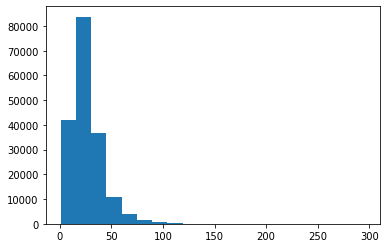

In [ ]:
# Checking the distribution
import matplotlib.pyplot as plt
plt.hist(sent_len, bins = 20);

Finding out number of words on an average for most of the sentences in the dataset. 
* Answer: 55 (Most of the sentences(95%) are 55 words long).

In [ ]:
# How long of a sentence length covers 95% of examples.
output_seq_len = int(np.percentile(sent_len, 95))
output_seq_len

55

In [ ]:
# Max seq len 
max(sent_len)

296

### Create text vectorizer layer

In [ ]:
import numpy as np
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
max_tokens = 68000
max_length = 55
text_vectorizer = TextVectorization(max_tokens = max_tokens, # number of words in vocabulary
                                    output_sequence_length = output_seq_len, # desired output length of vectorized sequences
                                    output_mode = "int")

In [ ]:
# adapt text_vectorizer to training data
text_vectorizer.adapt(train_sentences)

In [ ]:
# test out text vectorizer to random sentences
import random
target_sentence = random.choice(train_sentences)
vectorized_sentence = text_vectorizer([target_sentence])
print(f"target_text: {target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nvectorized_text:\n {vectorized_sentence}")


target_text: all patients were less than @ years of age and underwent thawed et following all embryo cryopreservation , and were randomly divided into two groups for thawed et using a conventional hormone replacement cycle with or without prostaglandin derivatives ( prostaglandin or conventional group ) .

Length of text: 46

vectorized_text:
 [[   62    12     9   211    42    64     4   103     3   352 21578  1890
    240    62  3532 12184     3     9    92   471   143    51    24    11
  21578  1890    59     8   366  1133  1075  1299     7    16   159  5329
  13389  5329    16   366    13     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words: {(rct_20k_text_vocab[:5])}")
print(f"Least common words: {(rct_20k_text_vocab[-5:])}")

Number of words in vocab: 64841
Most common words: ['', '[UNK]', 'the', 'and', 'of']
Least common words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get config of text_vectorizer
text_vectorizer.get_config() # list all the parameters

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8'}

### Create custom text embedding

In [ ]:
# create token embedding layer.
embedding_layer = tf.keras.layers.Embedding(input_dim = len(rct_20k_text_vocab), # length of the vocabulary
                                            output_dim = 128,
                                            mask_zero = True, # use masking to handle variable sequence length (save space) 
                                            name = "token_embedding")

In [ ]:
# Example of embedding.
print(f"Normal Text:\n {target_sentence}\n")
vectorized_text = text_vectorizer([target_sentence])
embedded_text = embedding_layer(vectorized_text)
print(f"vectorized_text:\n {vectorized_text}\n")
print(f"Embedded Text:\n {embedded_text}\n")
print(f"embedded_text_shape: {embedded_text.shape}")

Normal Text:
 all patients were less than @ years of age and underwent thawed et following all embryo cryopreservation , and were randomly divided into two groups for thawed et using a conventional hormone replacement cycle with or without prostaglandin derivatives ( prostaglandin or conventional group ) .

vectorized_text:
 [[   62    12     9   211    42    64     4   103     3   352 21578  1890
    240    62  3532 12184     3     9    92   471   143    51    24    11
  21578  1890    59     8   366  1133  1075  1299     7    16   159  5329
  13389  5329    16   366    13     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Embedded Text:
 [[[-0.04246172  0.01873937  0.02188081 ... -0.04982731  0.04051857
   -0.01766893]
  [ 0.01841477  0.02167535  0.01623404 ...  0.01653444 -0.0431785
   -0.01436417]
  [-0.04497904  0.01230631 -0.01240499 ...  0.0186385   0.02579657
   -0.00782277]
  ...
  [-0.00403551 -0.02825637  0.01546924 ...  0.0031116  -0.03

Embedding layer is **learnable**

## Creating datasets

In [ ]:
# Turn data into in tf datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Take tensor slice datasets and turn them into prefetched datsets
train_dataset = train_dataset.batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv 1D with token embeddings

In [ ]:
SAVE_DIR = "model_logs"

In [ ]:
inputs = tf.keras.layers.Input(shape = (1, ), dtype = tf.string)
x = text_vectorizer(inputs)
x = embedding_layer(x)
x = tf.keras.layers.Conv1D(filters = 64,
                           kernel_size = 5, # layer will look at 5 words at any given time t
                           activation = "relu",
                           padding = "same")(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x) # Condense the o/p of our feature vector from conv layer
outputs = tf.keras.layers.Dense(5, activation = "softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch = int(0.1 * len(train_dataset)),
                              epochs = 5,
                              validation_data = valid_dataset,
                              validation_steps = int(0.1 * len(valid_dataset)),
                              callbacks = [create_tensorboard_callback(dir_name = SAVE_DIR,
                                                                       experiment_name = "model_1_Conv1D")])

saving TensorBoard log files to : model_logs/model_1_Conv1D/20230227-015845
Epoch 1/5
562/562 [==============================] - 38s 50ms/step - loss: 0.9125 - accuracy: 0.6389 - val_loss: 0.6837 - val_accuracy: 0.7357
Epoch 2/5
562/562 [==============================] - 7s 12ms/step - loss: 0.6568 - accuracy: 0.7556 - val_loss: 0.6370 - val_accuracy: 0.7673
Epoch 3/5
562/562 [==============================] - 6s 10ms/step - loss: 0.6190 - accuracy: 0.7741 - val_loss: 0.5981 - val_accuracy: 0.7819
Epoch 4/5
562/562 [==============================] - 4s 7ms/step - loss: 0.5914 - accuracy: 0.7879 - val_loss: 0.5808 - val_accuracy: 0.7896
Epoch 5/5
562/562 [==============================] - 5s 9ms/step - loss: 0.5929 - accuracy: 0.7915 - val_loss: 0.5656 - val_accuracy: 0.7962


In [ ]:
# Evaluate on all of the validation_dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5631 - accuracy: 0.8000


[0.5631474256515503, 0.8000463247299194]

In [ ]:
# Make predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs[:10], model_1_pred_probs.shape

945/945 [==============================] - 2s 2ms/step


(array([[4.9812564e-01, 2.0809442e-01, 4.8783366e-02, 1.8731922e-01,
         5.7677321e-02],
        [3.9092699e-01, 3.9679697e-01, 2.4939474e-02, 1.3465658e-01,
         5.2680016e-02],
        [1.6825826e-01, 3.2125900e-03, 1.3300249e-03, 8.2713693e-01,
         6.2132400e-05],
        [4.3336368e-05, 2.1860799e-04, 9.9877900e-01, 6.5491833e-05,
         8.9361618e-04],
        [6.1012809e-03, 8.5068405e-02, 6.0605997e-01, 3.1401850e-03,
         2.9963017e-01],
        [1.6264038e-02, 2.2115456e-02, 6.7845947e-01, 6.5661850e-03,
         2.7659479e-01],
        [7.5307413e-04, 2.4623121e-03, 6.5196139e-01, 3.6057655e-04,
         3.4446272e-01],
        [3.5540439e-02, 4.2952538e-02, 5.4235017e-01, 1.3571920e-02,
         3.6558494e-01],
        [1.2017196e-10, 8.2683232e-07, 2.1303968e-06, 1.9976477e-10,
         9.9999702e-01],
        [1.3776880e-02, 7.6468289e-01, 7.9030782e-02, 2.8310191e-02,
         1.1419925e-01]], dtype=float32), (30212, 5))

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis = 1) #returns maximum value's index number.
model_1_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 1, 3, 2, 2])>

In [ ]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [ ]:
val_labels_one_hot[:5], val_labels_encoded[:5]

(array([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]]), array([0, 0, 3, 2, 2]))

**Note** For calculating results val_labels_encoded are used instead of one hot encoded version cuz the model_1_preds consist label encoded structure.

In [ ]:
# Calculate model_1 results
model_1_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_1_preds)
model_1_results

{'accuracy': 80.00463392029657,
 'precision': 0.8000388779716006,
 'recall': 0.8000463392029658,
 'f1': 0.7968144092433923}

## Model 2: TensorFlow HUb Pretrained Feature Exctractor

In [ ]:
import tensorflow_hub as hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape = [],
                                        trainable = False,
                                        dtype = tf.string,
                                        name = "USE")

In [ ]:
# Test the sentence encoder layer

import random 
random_sentence = random.choice(train_sentences)
embedded_text = sentence_encoder_layer([random_sentence])
print(f"The random sentence is:\n {random_sentence}")
print(f"The embedded text is\n {embedded_text}")
print(f"The shape of embedded text is {embedded_text.shape}")

The random sentence is:
 formula acceptability was high and comparable for both formula feedings , regardless of hm supplementation .
The embedded text is
 [[-4.84584868e-02 -8.50226209e-02 -5.82480542e-02  2.11854223e-02
   1.80028714e-02 -4.54761349e-02 -4.95820493e-03 -6.42519146e-02
   6.91267923e-02  5.26817180e-02 -2.41181292e-02  8.02313983e-02
  -2.90598236e-02 -7.65465712e-03 -8.39102119e-02  4.56980057e-02
  -8.02621692e-02  6.82313368e-02  6.29004389e-02  6.12970330e-02
   5.00022657e-02 -3.45732793e-02 -4.04290222e-02  6.82289228e-02
   3.92675586e-02  5.31022921e-02 -5.09108119e-02  4.89909798e-02
  -3.50262411e-02  6.57040402e-02  5.05663082e-02  8.00017565e-02
   2.26624981e-02 -7.55253732e-02 -1.35601675e-02  3.72002870e-02
  -7.53839174e-03 -5.45592830e-02  4.36508618e-02  1.66390184e-02
   6.71791658e-02  1.76090170e-02  5.36774145e-03  4.64828350e-02
   3.06280553e-02  4.01224829e-02  6.50602877e-02  1.47683714e-02
   8.28813538e-02  3.09536811e-02 -1.59780087e-03 -4

In [ ]:
# model_2 = tf.keras.Sequential([
#     sentence_encoder_layer,
#     tf.keras.layers.Dense(64, activation = "relu"),
#     tf.keras.layers.Dense(5, activation = "softmax")
# ])

inputs = tf.keras.Input(shape = [], dtype = tf.string)
x = sentence_encoder_layer(inputs)
x = tf.keras.layers.Dense(128, activation = "relu")(x)
outputs = tf.keras.layers.Dense(5, activation = "softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name = "model_2_transferLearning")

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
model_2.summary()

Model: "model_2_transferLearning"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
model_2_history = model_2.fit(train_dataset,
                              steps_per_epoch = int(0.1 * len(train_dataset)),
                              epochs = 3,
                              validation_data = valid_dataset,
                              validation_steps = int(0.1 * len(valid_dataset)),
                              callbacks = [create_tensorboard_callback(dir_name = SAVE_DIR,
                                                                       experiment_name = "model_2_TransferLearning")])

saving TensorBoard log files to : model_logs/model_2_TransferLearning/20230227-020104
Epoch 1/3
562/562 [==============================] - 11s 13ms/step - loss: 0.9170 - accuracy: 0.6534 - val_loss: 0.7917 - val_accuracy: 0.6915
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7653 - accuracy: 0.7037 - val_loss: 0.7500 - val_accuracy: 0.7094
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7475 - accuracy: 0.7137 - val_loss: 0.7340 - val_accuracy: 0.7174


In [ ]:
# Evaluate on all of the validation dataset
model_2.evaluate(train_dataset)

5627/5627 [==============================] - 63s 11ms/step - loss: 0.7385 - accuracy: 0.7160


[0.7384904026985168, 0.7160075306892395]

In [ ]:
# Make predictions
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs.shape

945/945 [==============================] - 10s 10ms/step


(30212, 5)

In [ ]:
model_2_pred_probs[:1]

array([[0.44420144, 0.32547683, 0.00235409, 0.22105227, 0.00691529]],
      dtype=float32)

In [ ]:
# Turn into labels
model_2_preds = tf.argmax(model_2_pred_probs, axis = 1)
model_2_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 1, 3, 2, 4])>

In [ ]:
# Calculate model_2 results
model_2_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_2_preds)
model_2_results

{'accuracy': 71.76287567853834,
 'precision': 0.7174264972038783,
 'recall': 0.7176287567853833,
 'f1': 0.7146347430951713}

## Model 3: Conv1D with character embeddings

* The paper that is being replicated, states that they used a token and character-level embeddings.
In the previous model token-level embeddings were crated, but similar steps wrt the paper are needed to be taken if character level embeddings are to be used. 

### Create a charcter level tokenizer

In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
# Make function to split words into chars
def split_chars(text):
  return " ".join(list(text))

# Text splitting a non-character-level sequence into characters
split_chars(target_sentence)

'a l l   p a t i e n t s   w e r e   l e s s   t h a n   @   y e a r s   o f   a g e   a n d   u n d e r w e n t   t h a w e d   e t   f o l l o w i n g   a l l   e m b r y o   c r y o p r e s e r v a t i o n   ,   a n d   w e r e   r a n d o m l y   d i v i d e d   i n t o   t w o   g r o u p s   f o r   t h a w e d   e t   u s i n g   a   c o n v e n t i o n a l   h o r m o n e   r e p l a c e m e n t   c y c l e   w i t h   o r   w i t h o u t   p r o s t a g l a n d i n   d e r i v a t i v e s   (   p r o s t a g l a n d i n   o r   c o n v e n t i o n a l   g r o u p   )   .'

In [ ]:
" ".join(list(train_sentences[0])) # actual working of the above function with an example

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [ ]:
# Split sequence-level data splits into char-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
# What's the avg charater len?
char_len = [len(char) for char in train_sentences]
avg_char_len = np.mean(char_len)
avg_char_len

149.3662574983337

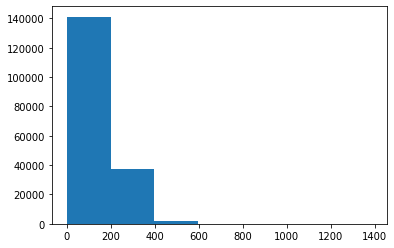

In [ ]:
# Check the distribution of our sequence at charcter-level
plt.hist(char_len, bins = 7);

In [ ]:
print(max(char_len))

1386


In [ ]:
# Find What character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_len, 95))
output_seq_char_len

290

In [ ]:
import string
sentence = "nishant"
string.digits, string.ascii_lowercase, string.punctuation


('0123456789',
 'abcdefghijklmnopqrstuvwxyz',
 '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')

In [ ]:
# Get all keyboard characters

import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
len(alphabet)


68

* This is the length that is the value of max_tokens for the text_vectorizer layer
* max_tokens = 68 means there are 68 different types of characters, 
including numbers, aplhabets and punctuations
* Also max_tokens means, how many different types of charcters/words are there in a particular char_dataset or word_dataset, respectively.

In [ ]:
# create char level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV (out of vocab) respectively
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_mode = "int",
                                    output_sequence_length = output_seq_char_len,
                                    name = "char_vectorizer")

In [ ]:
# Adapt to the train_sentences 
char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in the character vocab are: {len(char_vocab)}")
print(f"Five most common characters are: {char_vocab[:5]}")
print(f"5 Least common characters in the vocab are: {char_vocab[-5:]}")

Number of different characters in the character vocab are: 28
Five most common characters are: ['', '[UNK]', 'e', 't', 'i']
5 Least common characters in the vocab are: ['k', 'x', 'z', 'q', 'j']


In [ ]:
import random 
target_char = random.choice(train_chars)
char_vectorized_output = char_vectorizer(target_char)

print(f"-> The text before char vectorization is \n\n {target_char}\n\n")
print(f"-> The length of target_char is: {len(target_char.split())}")
print(f"\n->The character tokenized text is\n\n {char_vectorized_output}\n")
print(f"-> The shape of character tokenized text is: {char_vectorized_output.shape}")

-> The text before char vectorization is 

 t h e   p r i m a r y   o u t c o m e   w a s   a n   a n a l y s i s   o f   t h e   f e e d b a c k   c o n v e r s a t i o n   b e t w e e n   f a c u l t y   a n d   a   s i m u l a t e d   r e s i d e n t   (   a c t o r   )   b y   u s i n g   a v e r a g e s   o f   s i x   e l e m e n t s   o f   a   b e h a v i o r a l l y   a n c h o r e d   r a t i n g   s c a l e   a n d   a n   o b j e c t i v e   s t r u c t u r e d   a s s e s s m e n t   o f   f e e d b a c k   .


-> The length of target_char is: 204

->The character tokenized text is

 [ 3 13  2 14  8  4 15  5  8 19  7 16  3 11  7 15  2 20  5  9  5  6  5  6
  5 12 19  9  4  9  7 17  3 13  2 17  2  2 10 22  5 11 23 11  7  6 21  2
  8  9  5  3  4  7  6 22  2  3 20  2  2  6 17  5 11 16 12  3 19  5  6 10
  5  9  4 15 16 12  5  3  2 10  8  2  9  4 10  2  6  3  5 11  3  7  8 22
 19 16  9  4  6 18  5 21  2  8  5 18  2  9  7 17  9  4 24  2 12  2 15  2
  6  3  9  7 17  5 22  2 13  5 

In [ ]:
output_seq_char_len

290

### Creating the character level embedding layer

In [ ]:
# Creating the character level embedding layer
char_embedding_layer = tf.keras.layers.Embedding(input_dim = len(char_vocab), # no of different chaaracters in the vocab
                                                 output_dim = 25, # how long should be the length or dimension of the o/p vector (25 is the length of o/p char embedding layer in the PubMed 200k rct)
                                                 mask_zero = True,
                                                 name = "char_embed")

In [ ]:
# Ceck out the char level embedding layer
import random
target_char = random.choice(train_chars)
char_tokenized_text = char_vectorizer([target_char])
char_embed_vector = char_embedding_layer(char_tokenized_text)
print(f"The normal text is:\n\n {target_char}")
print(f"\nChar_Tokenized text is\n\n {char_tokenized_text}")
print(f"\nShape of Tokenized text is {char_tokenized_text.shape}")
print(f"\nThe embedded vector is:\n\n {char_embed_vector}\n")
print(f"Shape of embedded vector is: {char_embed_vector.shape}")

The normal text is:

 w e   r e c r u i t e d   @   f e m a l e   p a t i e n t s   (   @   @   y e a r s   o l d   )   w i t h   t r e a t m e n t - r e s i s t a n t   u n i p o l a r   m a j o r   d e p r e s s i o n   (   h a m i l t o n   d e p r e s s i o n   r a t i n g   s c a l e   - l s b -   h d r s   - r s b -   s c o r e   @   )   w h o   w e r e   o n   a   s t a b l e   a n t i d e p r e s s a n t   t r e a t m e n t   .

Char_Tokenized text is

 [[20  2  8  2 11  8 16  4  3  2 10 17  2 15  5 12  2 14  5  3  4  2  6  3
   9 19  2  5  8  9  7 12 10 20  4  3 13  3  8  2  5  3 15  2  6  3  8  2
   9  4  9  3  5  6  3 16  6  4 14  7 12  5  8 15  5 27  7  8 10  2 14  8
   2  9  9  4  7  6 13  5 15  4 12  3  7  6 10  2 14  8  2  9  9  4  7  6
   8  5  3  4  6 18  9 11  5 12  2 12  9 22 13 10  8  9  8  9 22  9 11  7
   8  2 20 13  7 20  2  8  2  7  6  5  9  3  5 22 12  2  5  6  3  4 10  2
  14  8  2  9  9  5  6  3  3  8  2  5  3 15  2  6  3  0  0  0  0  0  0  0
   0  0  0  0  0

`Feature_vector`
* In the above example the output is the 25 long feature vector.
Therefore the embedding layer gives us the feature vector

`mask_zero = True`
* The process of informing the Model that some part of the Data is actually Padding and should be ignored is called `Masking`.

### Build a Conv1D model with character_level tokenization and emebedding layers

In [ ]:
inputs = tf.keras.Input(shape = (1, ), dtype = tf.string)
vectorized = char_vectorizer(inputs)
embedding_layer = char_embedding_layer(vectorized)
conv_layer = tf.keras.layers.Conv1D(filters = 128,
                                    kernel_size = 5,
                                    padding = "same",
                                    activation = "relu")(embedding_layer)
another_layer = tf.keras.layers.Dense(64, activation = "relu")(conv_layer)                                    
normalized = tf.keras.layers.GlobalMaxPool1D()(another_layer)                                    
output_layer = tf.keras.layers.Dense(5, activation = "softmax")(normalized)
model_3 = tf.keras.Model(inputs, output_layer, name = "Char_embedding_model")                                   


In [ ]:
model_3.summary()

Model: "Char_embedding_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 128)          16128     
                                                                 
 dense_3 (Dense)             (None, 290, 64)           8256      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                               

In [ ]:
model_3.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
# create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)
valid_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch= int(0.1 * len(train_char_dataset)),
                              epochs = 5,
                              validation_data= valid_char_dataset,
                              validation_steps= int(0.1 * len(valid_char_dataset)),
                              callbacks = [create_tensorboard_callback(dir_name = SAVE_DIR,
                                                                       experiment_name = "model_3_charLevel_embeds")])

saving TensorBoard log files to : model_logs/model_3_charLevel_embeds/20230227-020326
Epoch 1/5
562/562 [==============================] - 7s 10ms/step - loss: 1.2027 - accuracy: 0.5032 - val_loss: 0.9835 - val_accuracy: 0.6017
Epoch 2/5
562/562 [==============================] - 4s 7ms/step - loss: 0.9630 - accuracy: 0.6142 - val_loss: 0.9046 - val_accuracy: 0.6433
Epoch 3/5
562/562 [==============================] - 4s 6ms/step - loss: 0.9036 - accuracy: 0.6433 - val_loss: 0.8509 - val_accuracy: 0.6695
Epoch 4/5
562/562 [==============================] - 5s 8ms/step - loss: 0.8454 - accuracy: 0.6704 - val_loss: 0.8163 - val_accuracy: 0.6805
Epoch 5/5
562/562 [==============================] - 4s 7ms/step - loss: 0.8259 - accuracy: 0.6798 - val_loss: 0.8169 - val_accuracy: 0.6872


In [ ]:
# Evaluate the model_3
model_3.evaluate(valid_char_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.8239 - accuracy: 0.6827


[0.8239185810089111, 0.6826757788658142]

In [ ]:
model_3_pred_probs = model_3.predict(valid_char_dataset)
model_3_pred_probs[:5]

945/945 [==============================] - 4s 4ms/step


array([[0.40483138, 0.35161936, 0.02567575, 0.20373252, 0.0141409 ],
       [0.16169724, 0.73522896, 0.00435953, 0.07719199, 0.0215222 ],
       [0.167426  , 0.29428697, 0.06189859, 0.44266966, 0.03371879],
       [0.01529025, 0.01952993, 0.9240409 , 0.00911061, 0.03202822],
       [0.01795222, 0.07836084, 0.85704666, 0.00780195, 0.03883832]],
      dtype=float32)

In [ ]:
# Convert predictions to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis = 1)
model_3_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 1, 3, 2, 2])>

In [ ]:
model_3_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_3_preds)
model_3_results

{'accuracy': 68.26757579769628,
 'precision': 0.7023736263347728,
 'recall': 0.6826757579769628,
 'f1': 0.6872941381068012}

In [ ]:
model_2_results

{'accuracy': 71.76287567853834,
 'precision': 0.7174264972038783,
 'recall': 0.7176287567853833,
 'f1': 0.7146347430951713}

One_hot_encoded data is used for fitting and training the model, whereas the label encoded data is used for comapring and getting results (as we have to comapre apples with apples)

## Model 4: Combining pretrained token embeddings + characters
1. Create a token-level embedding model (similar to `model_1`)
2. Create a character-level model (similar to `model_3`)
3. Combine 1 and 2 with a concatenate (`layers.Concatenate`)
4. Build a series of o/p layers on top of step 3 similar to figure 1 and section 4.2 of paper(`1612.05251` of arxiv.org)
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as o/p.

In [ ]:
# # 1. Setup token inputs/model
# token_inputs = tf.keras.layers.Input(shape = [], dtype = tf.string)
# token_embeddings = sentence_encoder_layer(token_inputs)
# token_outputs = tf.keras.layers.Dense(128, activation = "relu")(token_embeddings)
# token_model = tf.keras.Model(inputs = token_inputs,
#                              outputs = token_outputs)

In [ ]:
# # 2. Create a character level model
# char_inputs = tf.keras.layers.Input(shape = (1, ), dtype = tf.string)
# char_vectorized_values = char_vectorizer(char_inputs)
# char_embeddings = char_embedding_layer(char_vectorized_values)
# char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(char_embeddings)

# char_model = tf.keras.Model(inputs = char_inputs,
#                             outputs = char_bi_lstm)

In [ ]:
# # 3. Concatenate token and char inputs (create hybrid token embedding)
# token_char_concat = tf.keras.layers.Concatenate(name = "token_char_hybrid")([token_model.output,
#                                                                              char_model.output])

In [ ]:
# # 4. Create o/p layers adding in Dropout
# combined_dropout = tf.keras.layers.Dropout(0.5)(token_char_concat)
# combined_dense = tf.keras.layers.Dense(128, activation = "relu")(combined_dropout)
# final_dropout = tf.keras.layers.Dropout(0.5)(combined_dense)
# output_layer = tf.keras.layers.Dense(5, activation = "softmax")(final_dropout)


# # 5. Construct model with char and token inputs
# model_4 = tf.keras.Model(inputs = [token_model.input, char_model.input],
#                          outputs = output_layer,
#                          name = "model_4_token_char_embeddings")

In [ ]:
# model_4.summary()

In [ ]:
# model_4.compile(loss = "categorical_crossentropy",
#                 optimizer = tf.keras.optimizers.Adam(),
#                 metrics = ["accuracy"])

In [ ]:
# 1. Setup token inputs/model
# 2. Create a character level model
# 3. Concatenate token and char inputs (create hybrid token embedding)
# 4. Create o/p layers adding in Dropout
# 5. Construct model with char and token inputs


# 1.
token_inputs = tf.keras.layers.Input(shape = [], dtype = tf.string, name = "token_input")
embedding_vectors = sentence_encoder_layer(token_inputs)
token_outputs = tf.keras.layers.Dense(128, activation= "relu")(embedding_vectors)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_outputs)


# 2.
char_inputs = tf.keras.layers.Input(shape = (1, ), dtype = tf.string, name = "char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding_layer(char_vectors)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

# 3. 
token_char_concat = tf.keras.layers.Concatenate(name = "token_char_concatenate")([token_model.output, char_model.output])

# 4. 
dropout_layer = tf.keras.layers.Dropout(0.5)(token_char_concat)
combined_dense = tf.keras.layers.Dense(128, activation = "softmax")(dropout_layer)
final_dropout = tf.keras.layers.Dropout(0.5)(combined_dense)
output_layer = tf.keras.layers.Dense(num_classes, activation = "softmax")(final_dropout)

# 5. 
model_4 = tf.keras.Model(inputs = [token_model.input, char_model.input],
                         outputs = output_layer,
                         name = "model_4_hybrid")


In [ ]:
model_4.summary()

Model: "model_4_hybrid"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 USE (KerasLayer)               (None, 512)          256797824   ['token_input[0][0]'

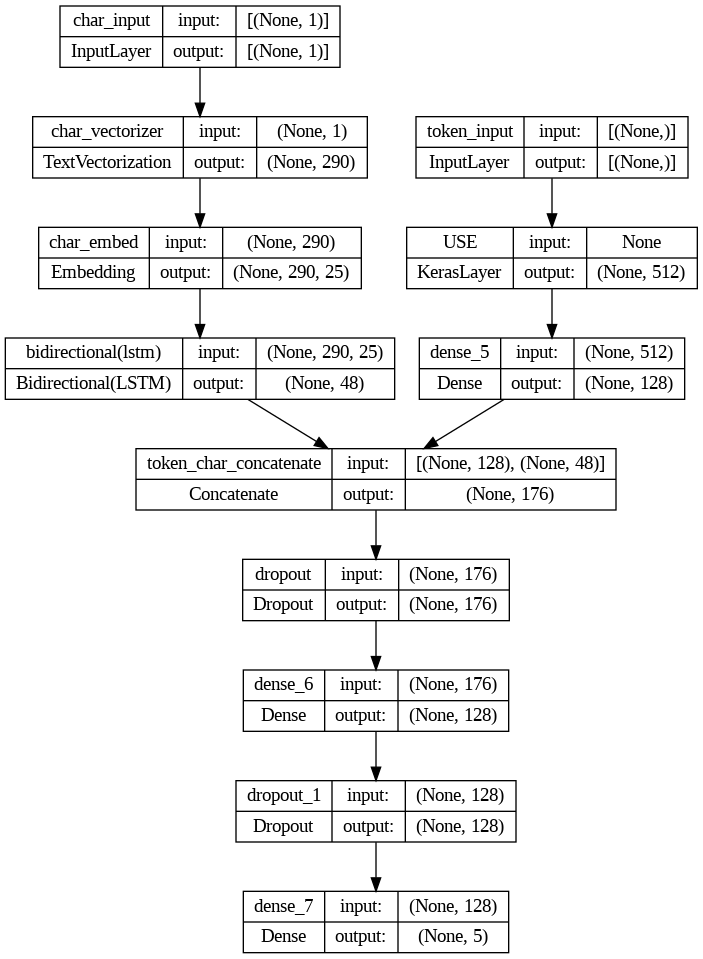

In [ ]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4, show_shapes = True)

In [ ]:
model_4.compile(loss = "categorical_crossentropy",
                optimizer = tf.optimizers.Adam(),
                metrics = ["accuracy"])

### Combining token and character data into a tf.data.Dataset

In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data =  tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) #make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

# Preparing val dataset
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

# Prefetch and batch val dataset
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Preparing test dataset
test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels))

# Prefetch and batch test dataset 
test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character-level sequences

In [ ]:
model_4_history = model_4.fit(train_char_token_dataset,
                              steps_per_epoch = int(0.1 * len(train_char_token_dataset)),
                              epochs = 5,
                              validation_data = val_char_token_dataset,
                              validation_steps = int(0.1 * len(val_char_token_dataset)))

Epoch 1/5
562/562 [==============================] - 44s 60ms/step - loss: 1.3742 - accuracy: 0.4446 - val_loss: 1.1564 - val_accuracy: 0.6130
Epoch 2/5
562/562 [==============================] - 31s 56ms/step - loss: 1.1673 - accuracy: 0.5438 - val_loss: 1.0398 - val_accuracy: 0.6263
Epoch 3/5
562/562 [==============================] - 25s 44ms/step - loss: 1.1020 - accuracy: 0.5666 - val_loss: 0.9837 - val_accuracy: 0.6307
Epoch 4/5
562/562 [==============================] - 28s 50ms/step - loss: 1.0493 - accuracy: 0.5800 - val_loss: 0.9413 - val_accuracy: 0.6363
Epoch 5/5
562/562 [==============================] - 26s 46ms/step - loss: 1.0375 - accuracy: 0.5891 - val_loss: 0.9089 - val_accuracy: 0.6509


In [ ]:
# Evaluate the model on all of the val dataset.
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 19s 20ms/step - loss: 0.9089 - accuracy: 0.6579


[0.9089277386665344, 0.6578842997550964]

In [ ]:
# Make preds with the model
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs[:1]

945/945 [==============================] - 21s 19ms/step


array([[0.29139057, 0.3311771 , 0.10502677, 0.17033838, 0.10206716]],
      dtype=float32)

In [ ]:
model_4_pred_probs.shape

(30212, 5)

In [ ]:
# Convert pred_probs to pred labels
model_4_preds = tf.argmax(model_4_pred_probs, axis = 1)
model_4_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 1, 1, 2, 4])>

In [ ]:
model_4_preds.shape

TensorShape([30212])

In [ ]:
# Calculate results
model_4_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_4_preds)
model_4_results

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 65.78842843903084,
 'precision': 0.6010724284799769,
 'recall': 0.6578842843903084,
 'f1': 0.6222111602966867}

## Model 5: Pretrained token embeddings + character embeddings + positional embeddings

`Feature Enginnering:` Taking non-obvious features from the data and encoding them numerically to help our model learn

📝 **Note:** Any engineered features used to train a model need to be available at test time.

### Create positional embeddings

In [ ]:
# How many line numbers are there
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

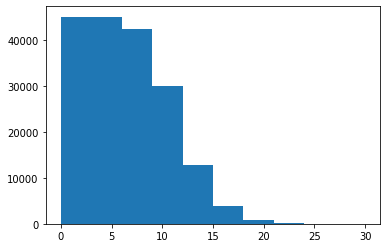

In [ ]:
# Check the distribution of "line number" column
plt.hist(train_df["line_number"]);

In [ ]:
np.percentile(train_df["line_number"], 95)

13.0

In [ ]:
# One hot encode line_number using tf
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth = 15)
val_line_number_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth = 15)
test_line_number_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth = 15)

In [ ]:
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape, val_line_number_one_hot[:10], val_line_number_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]),
 <tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
     

In [ ]:
# How many different total line values are there
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

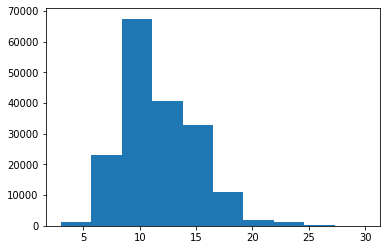

In [ ]:
# Check the distribution of total "total_lines" column
plt.hist(train_df["total_lines"]);

In [ ]:
train_total_line_numbers_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth = 20)
val_total_line_numbers_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth = 20)
test_total_line_numbers_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth = 20)

In [ ]:
train_total_line_numbers_one_hot[:10], train_total_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

In [ ]:
# check the coverage of a "total_lines" value of 20
np.percentile(train_df["total_lines"], 95)

18.0

18 is the length that covers the 95% of the abstract strings.

### Building a token level model

1. Create a token level model
2. Create a character level model
3. Create a model for the "line_number" feature
4. Create a model for "total_lines" feature
5. Combine the outputs of 1 and 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4, 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribried embedding and output label probabilitites
8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a tf.keras.Model

In [ ]:
# 1. Token Inputs (Tf_Hub layer "USE")
token_inputs = tf.keras.layers.Input(shape = [], dtype = tf.string, name = "token_inputs")
x = sentence_encoder_layer(token_inputs)
token_outputs = tf.keras.layers.Dense(128, activation = "relu")(x)
token_model = tf.keras.Model(token_inputs,
                             token_outputs)

# 2. Char Inputs
char_inputs = tf.keras.layers.Input(shape = (1, ), dtype = tf.string, name = "char_inputs")
x = char_vectorizer(char_inputs)
x = char_embedding_layer(x)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(x)
char_model = tf.keras.Model(char_inputs,
                            char_bi_lstm)

# 3. Line number model
line_number_inputs = tf.keras.layers.Input(shape = (15,), dtype = tf.float32, name = "Line_number_inputs")
line_number_outputs = tf.keras.layers.Dense(32, activation = "relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs,
                                   line_number_outputs)

# 4. Total Lines Model
total_lines_inputs = tf.keras.layers.Input(shape = (20, ), dtype = tf.float32, name = "Total_lines_inputs")
total_lines_outputs = tf.keras.layers.Dense(32, activation = "relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs,
                                   total_lines_outputs)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = tf.keras.layers.Concatenate(name = "token_char_hybrid_embedding")([token_model.output, 
                                                                                         char_model.output])

z = tf.keras.layers.Dense(256, activation = "relu")(combined_embeddings)
z = tf.keras.layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings
tribrid_embeddings = tf.keras.layers.Concatenate(name = "combined_token_positional_embedding")([line_number_model.output,
                                                                                                total_lines_model.output,
                                                                                                z])

# 7. Create output_layer.
output_layer = tf.keras.layers.Dense(num_classes, activation = "softmax", name = "output_layer")(tribrid_embeddings)

# 8. Put together model with all kinds of inputs.
tribrid_model_5 = tf.keras.Model(inputs = [line_number_model.input,
                                           total_lines_model.input,
                                           token_model.input,
                                           char_model.input],
                                 outputs = output_layer,
                                 name = "tribrid_model_5")

**Note:** A dense layer on its own is effectively an embedding

In [ ]:
tribrid_model_5.summary()

Model: "tribrid_model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 USE (KerasLayer)               (None, 512)          256797824   ['token_inputs[0][0

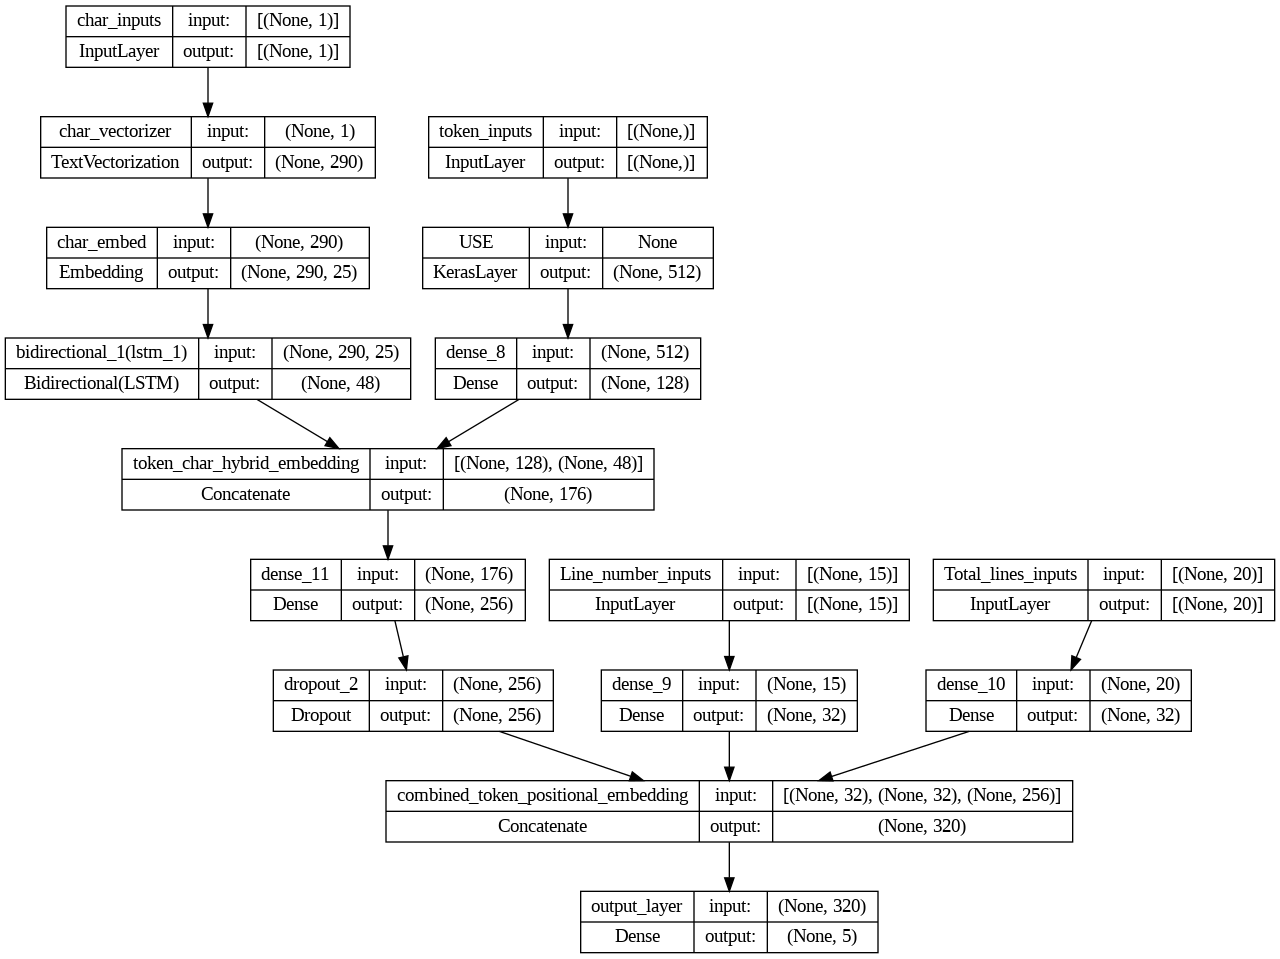

In [ ]:
# Plot model_5 to explore it visually...
from keras.utils import plot_model
plot_model(tribrid_model_5, show_shapes = True)

**Label Smoothing**

For Example, if the model gets too confident on a single class (e.g. its prediction probability is really high), it may get stuck on that class and not consider other classes...

Really Confident: `[0.0. 0.0, 1.0. 0.0, 0.0]`

What label smoothing does is it assigns some of the values from the highest pred prob to other classes, in turn, hopefully improving generalization: `[0.01, 0.01, 0.96, 0.01, 0.01]`

In [ ]:
# Compile token char and positional embedding model
tribrid_model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing= 0.2), # helps to prvent overfitting
                        optimizer = tf.keras.optimizers.Adam(),
                        metrics = ["accuracy"])

### Create tribrid embeddings using tf.data


In [ ]:
# train_line_number = train_df["line_number"].to_numpy()
# train_total_lines = train_df["total_lines"].to_numpy()
# train_line_number.shape, train_line_number[:5], train_total_lines[:5] ,train_total_lines.shape


# Combine token, char, line_number and total lines into a dataset 
train_pos_token_char_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_line_numbers_one_hot,
                                                                train_sentences, 
                                                                train_chars))

train_pos_token_char_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_pos_token_char_dataset = tf.data.Dataset.zip((train_pos_token_char_data, train_pos_token_char_labels))

# Prefetch and batch train dataset
train_pos_token_char_dataset = train_pos_token_char_dataset.batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

train_pos_token_char_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Validation Dataset

# Combine token, char, line_number and total lines into a val dataset 
val_pos_token_char_data = tf.data.Dataset.from_tensor_slices((val_line_number_one_hot,
                                                              val_total_line_numbers_one_hot,
                                                              val_sentences, 
                                                              val_chars))

val_pos_token_char_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_token_char_dataset = tf.data.Dataset.zip((val_pos_token_char_data, val_pos_token_char_labels))

# Prefetch and batch train dataset
val_pos_token_char_dataset = val_pos_token_char_dataset.batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

val_pos_token_char_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Test Dataset

# Combine token, char, line_number and total lines into a test dataset 
test_pos_token_char_data = tf.data.Dataset.from_tensor_slices((test_line_number_one_hot,
                                                               test_total_line_numbers_one_hot,
                                                               test_sentences,
                                                               test_chars))

test_pos_token_char_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_token_char_dataset = tf.data.Dataset.zip((test_pos_token_char_data, test_pos_token_char_labels))

# Prefetch and batch train dataset
test_pos_token_char_dataset = test_pos_token_char_dataset.batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

test_pos_token_char_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Fitting evaluating and making predictions with the tribrid_model_5

In [ ]:
model_5_history = tribrid_model_5.fit(train_pos_token_char_dataset,
                                      epochs = 5,
                                      steps_per_epoch = int(0.1 * len(train_pos_token_char_dataset)),
                                      validation_data = val_pos_token_char_dataset,
                                      validation_steps = int(0.1 * len(val_pos_token_char_dataset)))

Epoch 1/5
562/562 [==============================] - 45s 57ms/step - loss: 1.0932 - accuracy: 0.7251 - val_loss: 0.9852 - val_accuracy: 0.8012
Epoch 2/5
562/562 [==============================] - 27s 48ms/step - loss: 0.9704 - accuracy: 0.8151 - val_loss: 0.9512 - val_accuracy: 0.8245
Epoch 3/5
562/562 [==============================] - 24s 42ms/step - loss: 0.9508 - accuracy: 0.8231 - val_loss: 0.9422 - val_accuracy: 0.8308
Epoch 4/5
562/562 [==============================] - 29s 52ms/step - loss: 0.9408 - accuracy: 0.8360 - val_loss: 0.9313 - val_accuracy: 0.8288
Epoch 5/5
562/562 [==============================] - 33s 59ms/step - loss: 0.9382 - accuracy: 0.8335 - val_loss: 0.9244 - val_accuracy: 0.8398


In [ ]:
# Evaluate the model
tribrid_model_5.evaluate(val_pos_token_char_dataset)

945/945 [==============================] - 19s 21ms/step - loss: 0.9229 - accuracy: 0.8419


[0.9228819608688354, 0.8418840169906616]

In [ ]:
# Make predictions with the model
model_5_pred_probs = tribrid_model_5.predict(val_pos_token_char_dataset)
model_5_pred_probs[:5]

945/945 [==============================] - 22s 20ms/step


array([[0.6408657 , 0.08295716, 0.01450029, 0.24114941, 0.02052751],
       [0.65041053, 0.07977314, 0.06921575, 0.18846408, 0.01213645],
       [0.35518777, 0.10712424, 0.13914144, 0.34590924, 0.05263735],
       [0.03213811, 0.0584949 , 0.79733074, 0.02890133, 0.08313494],
       [0.04257974, 0.03821048, 0.77699155, 0.03125547, 0.11096278]],
      dtype=float32)

In [ ]:
# Converting pred probs to preds
model_5_preds = tf.argmax(model_5_pred_probs, axis = 1)
model_5_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 0, 2, 2])>

In [ ]:
# Calculate results
model_5_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_5_preds)
model_5_results

{'accuracy': 84.1884019594863,
 'precision': 0.8462193997977151,
 'recall': 0.8418840195948629,
 'f1': 0.8375153793457407}

## Comapring performances of all the models so far..

In [ ]:
all_model_results = pd.DataFrame({"baseline_results": baseline_results,
                                  "1_Conv1D_token_embed": model_1_results,
                                  "2_tf_hub_pretrained_USE": model_2_results,
                                  "3_Conv1D_char_embeds": model_3_results,
                                  "4_hybrid_pretrained_token_embeds_plus_char_embeds": model_4_results,
                                  "5_tribrid_pos_token_char": model_5_results})

all_model_results = all_model_results.transpose()

In [ ]:
# Reduce the accuracy as the same scale as other params
all_model_results["accuracy"] = all_model_results["accuracy"]/100

In [ ]:
all_model_results

,accuracy,precision,recall,f1
baseline_results,0.721832,0.718647,0.721832,0.698925
1_Conv1D_token_embed,0.800046,0.800039,0.800046,0.796814
2_tf_hub_pretrained_USE,0.717629,0.717426,0.717629,0.714635
3_Conv1D_char_embeds,0.682676,0.702374,0.682676,0.687294
4_hybrid_pretrained_token_embeds_plus_char_embeds,0.657884,0.601072,0.657884,0.622211
5_tribrid_pos_token_char,0.841884,0.846219,0.841884,0.837515


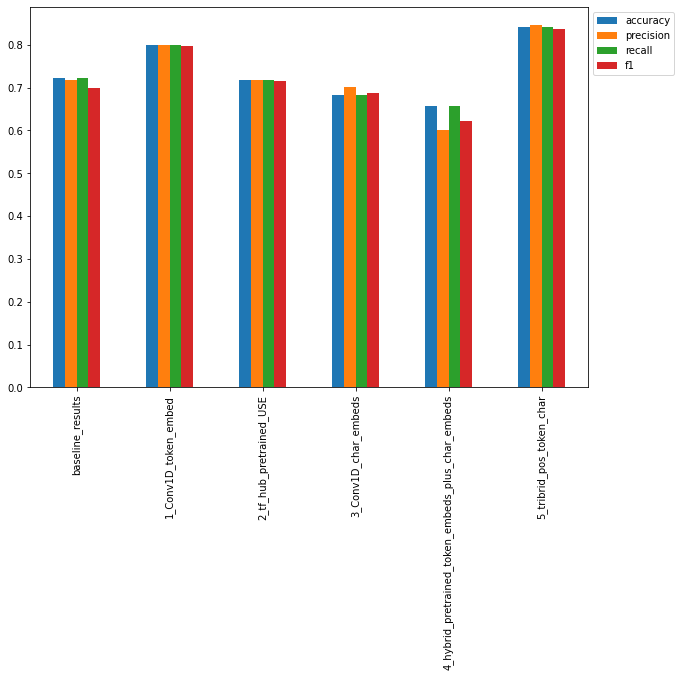

In [ ]:
# Plot and compare results
all_model_results.plot(kind = "bar", figsize = (10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

<AxesSubplot:>

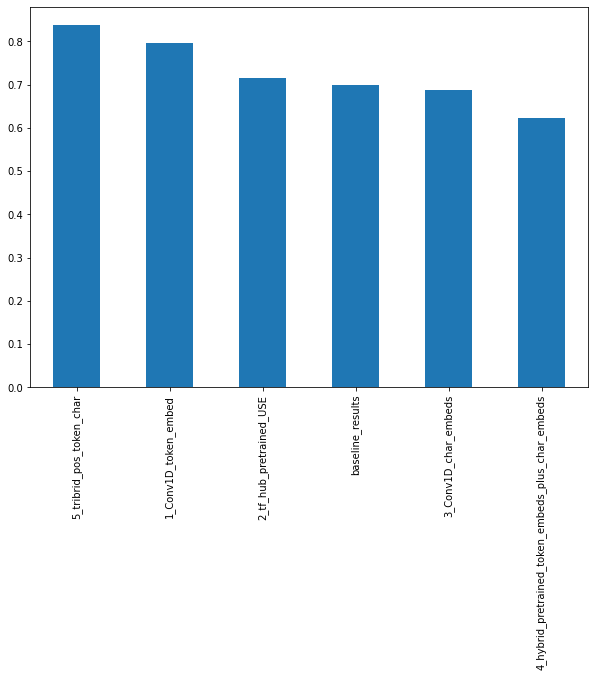

In [ ]:
all_model_results.sort_values("f1", ascending = False)["f1"].plot(kind = "bar", figsize = (10, 7))

## Save and load model

In [ ]:
tribrid_model_5.save("model_5_skimlit_tribrid")

In [ ]:
# load in model
loaded_model_5_saved_model_format = tf.keras.models.load_model("model_5_skimlit_tribrid")

In [ ]:
loaded_model_5_saved_model_format.evaluate(val_pos_token_char_dataset)

945/945 [==============================] - 24s 22ms/step - loss: 0.9229 - accuracy: 0.8419


[0.9228819608688354, 0.8418840169906616]

In [ ]:
print(tf.__version__)

2.11.0


In [ ]:
# make predictions on loaded model with 
loaded_model_pred_probs = loaded_model_5_saved_model_format.predict(val_pos_token_char_dataset)
loaded_model_pred_probs[:5]

945/945 [==============================] - 22s 20ms/step


array([[0.6408657 , 0.08295716, 0.01450029, 0.24114941, 0.02052751],
       [0.6504106 , 0.07977314, 0.06921577, 0.18846409, 0.01213645],
       [0.35518774, 0.10712423, 0.13914147, 0.34590918, 0.05263734],
       [0.03213811, 0.0584949 , 0.79733074, 0.02890133, 0.08313494],
       [0.04257973, 0.03821047, 0.77699167, 0.03125547, 0.11096273]],
      dtype=float32)

In [ ]:
loaded_model_preds = tf.argmax(loaded_model_pred_probs, axis = 1)
loaded_model_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 0, 2, 2])>

In [ ]:
loaded_model_results = calculate_results(y_true = val_labels_encoded,
                                         y_pred = loaded_model_preds)
loaded_model_results

{'accuracy': 84.1884019594863,
 'precision': 0.8462193997977151,
 'recall': 0.8418840195948629,
 'f1': 0.8375153793457407}

In [ ]:
assert loaded_model_results == model_5_results

`assert` gives an error if two comparable objects are'nt equal

In [ ]:
# check loaded model summary
loaded_model_5_saved_model_format.summary()

Model: "tribrid_model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 USE (KerasLayer)               (None, 512)          256797824   ['token_inputs[0][0